In [6]:
import numpy as np
from sympy import *
from scipy import stats
from scipy.optimize import lsq_linear
from scipy.optimize import curve_fit
from scipy.odr import *
from uncertainties import ufloat
from uncertainties import unumpy

import astropy.io.fits as pyfits
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.time import Time
from skyfield.api import load

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, style
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from sys import argv
import time
import os
import copy
import warnings

In [7]:
Data_list = np.array(['Q', 'K', 'K', 'Ka', 'B7', 'B6', 'B3', 'B4'])

Coord_gaufit_4A2_refit = \
                   [SkyCoord('03h29m10.430s', '+31d13m32.16s', frame='icrs'),\
                    SkyCoord('03h29m10.428s', '+31d13m32.09s', frame='icrs'),\
                    SkyCoord('03h29m10.429s', '+31d13m32.08s', frame='icrs'),\
                    SkyCoord('03h29m10.428s', '+31d13m32.08s', frame='icrs'),\
                    SkyCoord('03h29m10.430s', '+31d13m32.06s', frame='icrs'),\
                    SkyCoord('03h29m10.430s', '+31d13m32.07s', frame='icrs'),\
                    SkyCoord('03h29m10.430s', '+31d13m32.07s', frame='icrs'),\
                    SkyCoord('03h29m10.431s', '+31d13m32.04s', frame='icrs'),\
                   ] 

Time_list = [Time('2014-10-13'),\
             Time('2016-06-04'),\
             Time('2016-08-06'),\
             Time('2016-09-04'),\
             Time('2016-09-06'),\
             Time('2016-11-04'),\
             Time('2017-08-17'),\
             Time('2019-07-20'),\
            ]

# position uncertainties [arcsec]
Position_err_4A2_list = \
            [39e-3,\
             25e-3,\
             24e-3,\
             20e-3,\
             50e-3,\
             19e-3,\
             13e-3,\
             3e-3
            ]
# ra [deg]
Coord_4A2_ra = np.array([ufloat(SkyCoord('03h29m10.430s', '+31d13m32.16s', frame='icrs').ra.deg*36e5, 39.), \
                         ufloat(SkyCoord('03h29m10.428s', '+31d13m32.09s', frame='icrs').ra.deg*36e5, 25.), \
                         ufloat(SkyCoord('03h29m10.429s', '+31d13m32.08s', frame='icrs').ra.deg*36e5, 24.), \
                         ufloat(SkyCoord('03h29m10.428s', '+31d13m32.08s', frame='icrs').ra.deg*36e5, 22.), \
                         ufloat(SkyCoord('03h29m10.430s', '+31d13m32.06s', frame='icrs').ra.deg*36e5, 55.), \
                         ufloat(SkyCoord('03h29m10.430s', '+31d13m32.07s', frame='icrs').ra.deg*36e5, 19.), \
                         ufloat(SkyCoord('03h29m10.430s', '+31d13m32.07s', frame='icrs').ra.deg*36e5, 13.), \
                         ufloat(SkyCoord('03h29m10.431s', '+31d13m32.04s', frame='icrs').ra.deg*36e5, 3.), \
                        ])

# dec [deg]
Coord_4A2_dec = np.array([ufloat(SkyCoord('03h29m10.430s', '+31d13m32.16s', frame='icrs').dec.deg*36e5, 39.), \
                         ufloat(SkyCoord('03h29m10.428s', '+31d13m32.09s', frame='icrs').dec.deg*36e5, 25.), \
                         ufloat(SkyCoord('03h29m10.429s', '+31d13m32.08s', frame='icrs').dec.deg*36e5, 24.), \
                         ufloat(SkyCoord('03h29m10.428s', '+31d13m32.08s', frame='icrs').dec.deg*36e5, 22.), \
                         ufloat(SkyCoord('03h29m10.430s', '+31d13m32.06s', frame='icrs').dec.deg*36e5, 55.), \
                         ufloat(SkyCoord('03h29m10.430s', '+31d13m32.07s', frame='icrs').dec.deg*36e5, 19.), \
                         ufloat(SkyCoord('03h29m10.430s', '+31d13m32.07s', frame='icrs').dec.deg*36e5, 13.), \
                         ufloat(SkyCoord('03h29m10.431s', '+31d13m32.04s', frame='icrs').dec.deg*36e5, 3.), \
                        ])

color_list = ['red', 'orange', 'yellow', 'lime', 'green', 'blue', 'purple', 'black']

# Center: ALMA Band 4
i_center = -1
Coord_center_4A2 = Coord_gaufit_4A2_refit[i_center]
Coord_center_4A2_ra = Coord_4A2_ra[i_center]
Coord_center_4A2_dec = Coord_4A2_dec[i_center]
time_center_4A2 = Time_list[i_center]

In [8]:
# BCRS positions of Earth
def get_BCRS_earth(time_jd):

    '''
    Purpose:
    Get the Barycentric coordinates of the Earth [au] from the given time [Julian day]
    
    Input:
    - time_jd                  # Time of the observation [jd; float]
      
    Output:    
    - earth_bcrs.position.au   # Barycentric coordinates of the Earth  [au; ndarray]
                               # e.g., X, Y, Z, = [0.9438507  0.30264628 0.13106085]
    
    '''
    
    # convert time unit from Julian day (jd) to year, month, and date
    t_jd = Time(time_jd, format='jd')
    t_y = int(str(t_jd.datetime)[0:4])
    t_m = int(str(t_jd.datetime)[5:7])
    t_d = int(str(t_jd.datetime)[8:10])

    # The position of the Earth
    # python package: Skyfield 
    planets = load('de421.bsp')
    earth = planets['earth']

    ts = load.timescale()
    t = ts.utc(t_y, t_m, t_d)

    # From the center of the Solar System (Barycentric coord.)
    earth_bcrs = earth.at(t)
    
    return earth_bcrs.position.au

In [26]:
# The projections of the parallactic ellipse
def get_project_parallactic(ra_deg, dec_deg, earth_bcrs_au):
    
    '''
    Purpose:
    Get the projection over ra, dec of the parallactic eclipse (f_ra, f_dec) 
    from the given ra, dec, and the barycentric coordinates of the Earth
    
    Input:
    - ra_deg             # Right Ascension [deg]
    - dec_deg            # Declination [deg]
    - earth_bcrs_au      # BCRS positions of Earth [au]
    
    Output: 
    - f_ra               # projection over ra of the parallactic eclipse [au]
    - f_dec              # projection over dec of the parallactic eclipse [au]
    '''
    
    # corvert ra, dec from degree to rad
    ra_rad = np.deg2rad(ra_deg)
    dec_rad = np.deg2rad(dec_deg)
    
    # corvert BCRS_earth to X, Y, Z format
    X = earth_bcrs_au[0]  # [au]
    Y = earth_bcrs_au[1]  # [au]
    Z = earth_bcrs_au[2]  # [au]
    
    # projection over ra and dec of the parallactic eclipse (Seidelmann 1992)
    f_ra = np.divide(X*np.sin(ra_rad)-Y*np.cos(ra_rad), np.cos(dec_rad))
    f_dec = X*np.cos(ra_rad)*np.sin(ra_rad) + Y*np.sin(ra_rad)*np.sin(ra_rad) - Z*np.cos(dec_rad)

    return f_ra, f_dec


def get_radec(ra_ini, dec_ini, ra_0, dec_0, prop_ra, prop_dec, prllx, time_jd, time_diff):
    '''
    Purpose:
    Get the ra & dec from the original guessing ra & dec, stop the ra & dec
    
    Input:
    - ra_ini              # Initial Guess: Right Ascension [deg]
    - dec_ini             # Initial Guess: Declination [deg]
    - ra_0                # Fitting result: Right Ascension [deg]
    - dec_0               # Fitting result: Declination [deg]
    - prop_ra             # Proper motion in the direction of ra [mas yr-1]
    - prop_dec            # Proper motion in the direction of dec [mas yr-1]
    - prllx               # Parallax [mas yr-1]
    - time_jd             # Time of the observation [jd; float]
    - time_diff           # Time different: obs. of Fitting & Initial Guess [yr; float]
    
    
    Output:
    - ra_fin              # Finial value: Right Ascension [deg]
    - dec_fin             # Finial value: Declination [deg]
    
    '''
    
    # transfer the unit
    prllx_deg = mas2dec(prllx)
    prop_ra_deg = mas2dec(prop_ra)
    prop_dec_deg = mas2dec(prop_dec)
    
    # get the projection over ra and dec of the parallactic eclipse (Seidelmann 1992)
    f_ra = get_project_parallactic(ra_ini, dec_ini, get_BCRS_earth(time_jd))[0]
    f_dec = get_project_parallactic(ra_ini, dec_ini, get_BCRS_earth(time_jd))[1]
    
    ra_fin = ra_0   + prop_ra_deg*time_diff  + prllx_deg*f_ra
    dec_fin = dec_0 + prop_dec_deg*time_diff + prllx_deg*f_dec
    
    return ra_fin, dec_fin

In [27]:
# convert the unit from milliarcsecond to radius
def mas2rad(u_mas):
    return np.deg2rad(np.divide(u_mas, 36e5))

# convert the unit from milliarcsecond to deg
def mas2dec(u_mas):
    return np.divide(u_mas, 36e5)

# convert the unit from deg to milliarcsecond
def deg2mas(u_deg):
    return u_deg*36e5

#### Fitting without considering the parallax

y = a*x + b

$\alpha(t)$ = $\mu_{\alpha}$ cos$\delta$ $(t - t_{0}$) + $\alpha(t_{0})$

$\delta(t)$ = $\mu_{\delta}$ $(t - t_{0}$) + $\delta(t_{0})$

In [11]:
#----------------------------------------------------
# Fit the proper motion w/o considering the prarllax
#
# Assumption:
# (1) the parallax by the distance of 293 pc for the Perseus Molecular Cloud
parallax = 3.         # parallax [mas]
# (2) Set the center position to the ALMA Band 4 
i_std = 7          # ALMA Band 4 observation
# (3) fitting without Q band observation due to the poor resolution

###----------
# Convert the observation 
# (1) from list format to array
# (2) from ra, dec to the fitting y, x term 

# Set the empty list
x_ra_list, x_dec_list = [], []
y_ra_list, y_dec_list = [], []

ra_mas_list, dec_mas_list = [], []
time_jd_list, time_diff_yr_list = [], []
Position_err_4A2_mas_list = []

for i in range(1,8):

    # obtain the information of ra, dec, time from the observations
    ra_deg = Coord_gaufit_4A2_refit[i].ra.deg             # ra [deg; float]
    dec_deg = Coord_gaufit_4A2_refit[i].dec.deg           # dec [deg; float]
    Position_err_4A2_mas = Position_err_4A2_list[i]*1e3   # error of ra, dec [mas; float]
    
    time_ymd = Time_list[i]                               # time [y-m-d h:m:s; astropy.time.core.Time]
    time_jd = float(time_ymd.jd)                          # time [jd; float]
    time_std_ymd = Time_list[i_std]                       # time [y-m-d h:m:s; astropy.time.core.Time]
    time_std_jd = float(time_std_ymd.jd)                  # time [jd; float]
    time_diff_yr = np.divide(time_jd- time_std_jd, 365.)  # time difference  [yr; float]

    # corvert the unit of ra and dec from deg to mas
    ra_mas = deg2mas(ra_deg)                              # ra [mas; float]
    dec_mas = deg2mas(dec_deg)                            # dec [mas; float]
    
    y_ra = ra_mas                      # RA(t)    [mas]
    x_ra = time_diff_yr                # t - t_0  [yr]
    y_dec = dec_mas                    # Dec(t)   [mas]
    x_dec = time_diff_yr               # t - t_0  [yr]
    
    # get the prject of the Earth to calculate the parallax
    earth_bcrs_au = get_BCRS_earth(time_jd)
    f_ra, f_dec = get_project_parallactic(ra_deg, dec_deg, earth_bcrs_au)
    
    if i == i_std:
        f_ra_std = f_ra
        f_dec_std = f_dec

    #y_ra = np.divide( ra_mas - fa*parallax, np.cos(np.deg2rad(dec_deg)) ) # [mas]
    #y_ra = ra_mas - f_ra*parallax      # [mas]
    #x_ra = time_diff_yr                # [yr]
    #y_dec = dec_mas - f_dec*parallax   # [mas]
    #x_dec = time_diff_yr               # [yr]

    ra_mas_list.append(ra_mas)
    dec_mas_list.append(dec_mas) 
    time_jd_list.append(time_jd)
    time_diff_yr_list.append(time_diff_yr)
    Position_err_4A2_mas_list.append(Position_err_4A2_mas)
    
    y_ra_list.append(y_ra)
    x_ra_list.append(x_ra)
    y_dec_list.append(y_dec)
    x_dec_list.append(x_dec)

ra_mas_arr = np.array(ra_mas_list) 
dec_mas_arr = np.array(dec_mas_list) 
time_jd_arr = np.array(time_jd_list)
time_diff_yr_arr = np.array(time_diff_yr_list)
Position_err_4A2_mas_arr = np.array(Position_err_4A2_mas_list)
y_ra_arr = np.array(y_ra_list)          # RA(t)    [mas]
x_ra_arr = np.array(x_ra_list)          # t - t_0  [yr]
y_dec_arr = np.array(y_dec_list)        # Dec(t)   [mas]
x_dec_arr = np.array(x_dec_list)        # t - t_0  [yr]

###----------
# linear regression
# Python package numpy.polyfit with order = 1
z_ra_arr = np.polyfit(x_ra_arr, y_ra_arr, 1)       # Proper_motion_ra[mas yr-1]; ra_0[mas]
z_dec_arr = np.polyfit(x_dec_arr, y_dec_arr, 1)    # Proper_motion_dec[mas yr-1]; dec_0[mas]

#------------------
# Fitting result
print '#------------------'
print 'Fitting result:'
# the proper motion [mas yr-1]
proper_ra_fit_masyr = z_ra_arr[0]
proper_dec_fit_masyr = z_dec_arr[0]
print 'Proper motion in RA  = {0} [mas yr-1]'.format(proper_ra_fit_masyr)
print 'Proper motion in Dec = {0} [mas yr-1]'.format(proper_dec_fit_masyr)
print ''

# the position of the ALMA Band 4 without parallax [mas]
ra_0_fit_mas = z_ra_arr[1]
dec_0_fit_mas = z_dec_arr[1]
print 'The position of the ALMA Band 4 without parallax (i.e., fitting result)'
print 'RA  = {0} [mas]'.format(ra_0_fit_mas)
print 'Dec = {0} [mas]'.format(dec_0_fit_mas)

# compare the position of the ALMA Band 4 with parallax [mas]
ra_std_mas = deg2mas(Coord_gaufit_4A2_refit[i_std].ra.deg)
dec_std_mas = deg2mas(Coord_gaufit_4A2_refit[i_std].dec.deg)
print 'The position of the ALMA Band 4 with parallax (i.e., obs.)'
print 'RA  = {0} [mas]'.format(ra_std_mas)
print 'Dec = {0} [mas]'.format(dec_std_mas)
print ''

# the difference of the ra_0, ra_std & dec_0, dec_std
ra_0_diff_mas = ra_std_mas - ra_0_fit_mas
dec_0_diff_mas = dec_std_mas - dec_0_fit_mas
mag_0_diff_mas = np.sqrt(ra_0_diff_mas**2 + dec_0_diff_mas**2)
ra_obs_pallax_mas = f_ra_std*parallax
dec_obs_pallax_mas = f_dec_std*parallax
mag_obs_pallax_mas = np.sqrt(ra_obs_pallax_mas**2 + dec_obs_pallax_mas**2)
print 'The different of the ALMA Band 4 w/ & w/o parallax'
print 'From fitting'
print 'RA  = {0} [mas]'.format(ra_0_diff_mas)
print 'Dec  = {0} [mas]'.format(dec_0_diff_mas)
print 'Magnitude = {0} [mas]'.format(mag_0_diff_mas)
print 'From observation (i.e, f_ra, f_dec * parallax)'
print 'RA  = {0} [mas]'.format(ra_obs_pallax_mas)
print 'Dec  = {0} [mas]'.format(dec_obs_pallax_mas)
print 'Magnitude = {0} [mas]'.format(mag_obs_pallax_mas)
print 'Note: the position uncertainty is 3 mas'

#------------------
Fitting result:
Proper motion in RA  = 11.3440162829 [mas yr-1]
Proper motion in Dec = -12.5461759478 [mas yr-1]

The position of the ALMA Band 4 without parallax (i.e., fitting result)
RA  = 188256468.09 [mas]
Dec = 112412040.513 [mas]
The position of the ALMA Band 4 with parallax (i.e., obs.)
RA  = 188256465.0 [mas]
Dec = 112412040.0 [mas]

The different of the ALMA Band 4 w/ & w/o parallax
From fitting
RA  = -3.09033963084 [mas]
Dec  = -0.512803688645 [mas]
Magnitude = 3.13259742978 [mas]
From observation (i.e, f_ra, f_dec * parallax)
RA  = 3.03464347473 [mas]
Dec  = 0.0287043720612 [mas]
Magnitude = 3.0347792275 [mas]
Note: the position uncertainty is 3 mas


In [12]:
# the proper motion [mas yr-1]
proper_ra_fit_masyr = z_ra_arr[0]
proper_dec_fit_masyr = z_dec_arr[0]
print 'Proper motion in RA  = {0} [mas yr-1]'.format(proper_ra_fit_masyr)
print 'Proper motion in Dec = {0} [mas yr-1]'.format(proper_dec_fit_masyr)
print ''


# 
slope, intercept, r_value, p_value, std_err = stats.linregress(x_ra_arr,y_ra_arr)
print slope, intercept, r_value, p_value, std_err
print np.power(r_value, 2)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_dec_arr,y_dec_arr)
print slope, intercept, r_value, p_value, std_err

Proper motion in RA  = 11.3440162829 [mas yr-1]
Proper motion in Dec = -12.5461759478 [mas yr-1]

11.344016250982046 188256468.09033957 0.7377758856000475 0.05837571852620281 4.641844403234399
0.5443132573729343
-12.546175958824 112412040.51280366 -0.849861426784502 0.015446447978336886 3.4793169629947305


In [47]:
# Input parameter
i = 7
ra_ini = Coord_gaufit_4A2_refit[i].ra.deg
dec_ini = Coord_gaufit_4A2_refit[i].dec.deg
ra_0 = mas2dec(z_ra_arr[1])
dec_0 = mas2dec(z_dec_arr[1])
prop_ra = z_ra_arr[0]
prop_dec = z_dec_arr[0]
prllx = parallax
time_jd = Time_list[i].jd
time_diff = (Time_list[i].jd - Time_list[7].jd)/365

# set the initial different ra & dec as 100
ra_diff_mas = 100.
dec_diff_mas = 100.

epsilon = 1e-20

while ra_diff_mas > epsilon and dec_diff_mas > epsilon:
       
    ra_fin_deg, dec_fin_deg = get_radec(ra_ini, dec_ini, ra_0, dec_0, prop_ra, prop_dec, \
                                prllx, time_jd, time_diff)
    
    ra_diff_mas = deg2mas(ra_fin_deg - ra_ini)
    dec_diff_mas = deg2mas(dec_fin_deg - dec_ini)
    
    # replace the ra & dec using the result from the radec function 
    ra_ini = ra_fin_deg
    dec_ini = dec_fin_deg
    
    print ra_fin_deg, dec_fin_deg
    print ra_diff_mas, dec_diff_mas
 


52.2934642013842 31.22556681708557
6.124983119093486 0.5415080607917844
52.29346420138418 31.225566817085546
-5.1159076974727213e-08 -8.952838470577262e-08


In [ ]:

    
print ra_ini, dec_ini, ra_0, dec_0, prop_ra, prop_dec, prllx, time_jd, time_diff


ra_fin, dec_fin = get_radec(ra_ini, dec_ini, ra_0, dec_0, prop_ra, prop_dec, \
                            prllx, time_jd, time_diff)

ra_diff = ra_fin - ra_ini
dec_diff = dec_fin - dec_ini
print ra_fin, dec_fin

print deg2mas(ra_diff)
print deg2mas(dec_diff)

#---
ra_fin2, dec_fin2 = get_radec(ra_fin, dec_fin, ra_0, dec_0, prop_ra, prop_dec, \
                            prllx, time_jd, time_diff)

ra_diff2 = ra_fin2 - ra_fin
dec_diff2 = dec_fin2 - dec_fin
print deg2mas(ra_diff2)
print deg2mas(dec_diff2)

#---
ra_fin3, dec_fin3 = get_radec(ra_fin2, dec_fin2, ra_0, dec_0, prop_ra, prop_dec, \
                            prllx, time_jd, time_diff)

ra_diff3 = ra_fin3 - ra_fin2
dec_diff3 = dec_fin3 - dec_fin2
print deg2mas(ra_diff3)
print deg2mas(dec_diff3)




Beta: [1.06752023e+01 1.88256465e+08]
Beta Std Error: [1.79001021 1.42497094]
Beta Covariance: [[13.41331016  2.40453951]
 [ 2.40453951  8.50035315]]
Residual Variance: 0.238877391839
Inverse Condition #: 0.0815287731271
Reason(s) for Halting:
  Parameter convergence


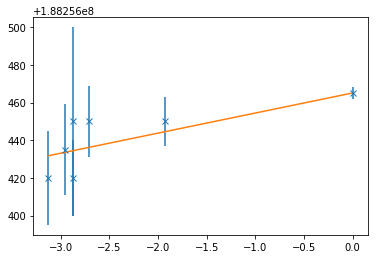

In [13]:
# Define a function (y = a*x + b in our case) to fit the data with.
def linear_func(p, x):
    a, b = p
    return a*x + b

# Create a model for fitting.
linear_model = Model(linear_func)

x = x_ra_arr
y = y_ra_arr
# Create a RealData object using our initiated data from above.
data = RealData(x, y, \
                sy=Position_err_4A2_mas_arr)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

x_fit = np.linspace(x[0], x[-1], 1000)
y_fit = linear_func(out.beta, x_fit)

plt.errorbar(x, y, yerr=Position_err_4A2_mas_arr, linestyle='None', marker='x')
plt.plot(x_fit, y_fit)

plt.show()

In [14]:
# curve_fit
def func(x, m, n):
    return m * x + n

popt, pcov = curve_fit(func, x, y)
perr = np.sqrt(np.diag(pcov))
print popt
print pcov
print perr


[1.11418706e+01 1.88256468e+08]
[[ 21.4771969   51.41738689]
 [ 51.41738689 145.70255084]]
[ 4.63434967 12.07073116]


In [ ]:
z_ra_arr = np.polyfit(x_ra_arr, y_ra_arr, 1)
print z_ra_arr

full_z_ra_arr = np.polyfit(x_ra_arr, y_ra_arr, 1, full=True)
full_z_dec_arr = np.polyfit(x_dec_arr, y_dec_arr, 1, full=True)
# Residuals of the least-squares fit
# the effective rank of the scaled Vandermonde coefficient matrix
# its singular values
# the specified value of rcond.
print full_z_ra_arr
print full_z_dec_arr

In [ ]:
print ra_mas_arr
print dec_mas_arr
print time_jd_arr
print time_diff_yr_arr
print Position_err_4A2_mas_arr

In [ ]:
# Plot the fitting result
# proper_ra * cos(dec)

Coord_gaufit_4A2_refit


plt.errorbar(x = time_diff_yr_arr, y = ra_mas_arr, \
             yerr = Position_err_4A2_mas_arr,\
             marker ='o', fmt='.')


# plot the fitting result
#t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
# y = a*x + b
# y = proper_ra*cos(dec)*x + ra_0
#y_ra_fit = z_ra_arr[0]*t + z_ra_arr[1]
#plt.plot(t, y_ra_fit)

# set the figure
plt.title('RA v.s. Time')
plt.xlabel('ObsTime - B4Time [yr]')
plt.ylabel(r'$\mu_{\alpha}$ $cos\,\delta$ [mas yr$^{\,-1}$]')
plt.grid()
plt.show()

In [ ]:
# Time

# get the time information from the observations
time_ymd = Time_list[i]                       # time [y-m-d h:m:s; astropy.time.core.Time]
time_jd = float(time_ymd.jd)                  # time [jd; float]
# time information from the reference data
time_std_ymd = Time_list[i_std]               # time [y-m-d h:m:s; astropy.time.core.Time]
time_std_jd = float(time_std_ymd.jd)          # time [jd; float]
# time difference
time_diff_yr = np.divide(time_jd - time_std_jd, 365.) # time difference  [yr; float]

# Convert time unit from y-m-d to jd
t0_jd = float(Time_list[0].jd)
tf_jd = float(Time_list[-1].jd)
t_std_jd = float(Time_list[i_std].jd)

# Convert time unit from jd to year
t0_yr = t0_jd/365.
tf_yr = tf_jd/365.
t_std_yr = t_std_jd/365.

# Time different from the first fitting plot (JVLA K) btw the reference (ALMA B4) [yr]
t0_diff_yr = t0_yr - t_std_yr
tf_diff_yr = tf_yr - t_std_yr

In [ ]:
# Plot the fitting result
# proper_ra * cos(dec)

plt.plot(x_ra_arr, y_ra_arr, 'o')


# plot the fitting result
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
# y = a*x + b
# y = proper_ra*cos(dec)*x + ra_0
y_ra_fit = z_ra_arr[0]*t + z_ra_arr[1]
plt.plot(t, y_ra_fit)

# set the figure
plt.title('Proper_RA v.s. Time')
plt.xlabel('ObsTime - B4Time [yr]')
plt.ylabel(r'$\mu_{\alpha}$ $cos\,\delta$ [mas yr$^{\,-1}$]')
plt.grid()
plt.show()

In [ ]:
# Plot the fitting result
# proper_dec

plt.plot(x_dec_arr, y_dec_arr, 'o')


# plot the fitting result
t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
# y = a*x + b
# y = proper_dec*x + dec_0
y_dec_fit = z_dec_arr[0]*t + z_dec_arr[1]
plt.plot(t, y_dec_fit)

# set the figure
plt.title('Proper_Dec v.s. Time')
plt.xlabel('ObsTime - B4Time [yr]')
plt.ylabel(r'$\mu_{\delta}$ [mas yr$^{\,-1}$]')
plt.grid()
plt.show()

In [ ]:
# try to plot the parallax
# need to solve the nonlinear equation to get ra, dec

t = 1.
parallax = 3.
ra_fit_0_mas = z_ra_arr[1]/1e3 - Coord_center_4A2.ra.deg*36e2
dec_fit_0_mas = z_dec_arr[1]/1e3 - Coord_center_4A2.dec.deg*36e2

time_ymd = Time_list[i]                       # time [y-m-d h:m:s; astropy.time.core.Time]
time_jd = float(time_ymd.jd)                  # time [jd; float]
time_std_ymd = Time_list[i_std]               # time [y-m-d h:m:s; astropy.time.core.Time]
time_std_jd = float(time_std_ymd.jd)          # time [jd; float]
time_diff_yr = np.divide(time_jd- time_std_jd, 365.) # time difference  [yr; float]
earth_bcrs_au = get_BCRS_earth(time_jd)
fa, fd = get_project_parallactic(ra_deg, dec_deg, earth_bcrs_au)
    
z_ra_arr[0]*t
z_dec_arr[0]*t


t0_jd = float(Time_list[0].jd)
tf_jd = float(Time_list[-1].jd)
t_std_jd = float(Time_list[7].jd)

t0_yr = t0_jd/365.
tf_yr = tf_jd/365.
t_std_yr = t_std_jd/365.

t0_diff_yr = t0_yr - t_std_yr
tf_diff_yr = tf_yr - t_std_yr

n = 20
t_jd = np.linspace(t0_jd, tf_jd, n)
t_diff = np.linspace(t0_diff_yr, tf_diff_yr, n)

t_jd = t0_jd
t_diff = t0_diff_yr

earth_bcrs_au = get_BCRS_earth(t_jd)
# corvert BCRS_earth to X, Y, Z format
X = earth_bcrs_au[0]  # [au]
Y = earth_bcrs_au[1]  # [au]
Z = earth_bcrs_au[2]  # [au]

#print X, Y, Z

# convert unit
ra_fit_0_rad = mas2rad(ra_fit_0_mas)
dec_fit_0_rad = mas2rad(dec_fit_0_mas)
z_ra_rad = mas2rad(z_ra_arr[0])
z_dec_rad = mas2rad(z_dec_arr[0])
parallax_rad = mas2rad(parallax)

fa, fd = get_project_parallactic(ra_deg, dec_deg, earth_bcrs_au)

ra = Symbol('ra')
dec = Symbol('dec')

#func_ra = (ra_fit_0_rad - ra + parallax_rad* (X*sin(ra)-Y*cos(ra)) )* (-2/(z_ra_rad*t_diff)) -1 - cos(2*dec)
#func_dec = parallax_rad* (X*sin(ra) - Y*cos(ra)) - cos(dec)

#func_ra = ra_fit_0_rad + z_ra_rad*t_diff + parallax_rad*((X*sin(ra)-Y*cos(ra))/cos(dec)) - ra
#func_dec = dec_fit_0_rad + z_dec_rad*t_diff + parallax_rad*(X*cos(ra)*sin(ra)+Y*sin(ra)*sin(dec)-Z*cos(dec)) - dec

#sol = solve((func_ra, func_dec), ra, dec)
#print sol

In [ ]:
# test for fitting including the err. of the data
i = 5

ra_diff = Coord_4A2_ra[i] - Coord_center_4A2_ra # [mas]
dec_diff = Coord_4A2_dec[i] - Coord_center_4A2_dec # [mas]
time_diff = (Time_list[i].jd - time_center_4A2.jd)/365. #[year]
cos_dec = unumpy.cos(Coord_4A2_dec[i]/36e5)

y_ra = ra_diff/(time_diff*cos_dec)
y_dec = dec_diff/time_diff
print ra_diff
print dec_diff

print Coord_4A2_dec[i]/36e5   # dec[deg]
print y_ra
print y_dec

print Time_list[i].jd
print time_diff

for i, data in enumerate(Data_list):
    
    ra = Coord_gaufit_4A2_refit[i].ra.hms
    dec  = Coord_gaufit_4A2_refit[i].dec
    # differece of Coord, each - B7 [mas]
    ra_diff = (Coord_center_4A2.ra.deg - Coord_gaufit_4A2_refit[i].ra.deg)*3600*1e3
    dec_diff = (Coord_gaufit_4A2_refit[i].dec.deg - Coord_center_4A2.dec.deg)*3600*1e3
    
    #print ra_diff, dec_diff

In [ ]:
print parallax_rad

In [ ]:
parallax = 3.
t0_jd = float(Time_list[0].jd)
tf_jd = float(Time_list[-1].jd)
t_std_jd = float(Time_list[7].jd)
t0_yr = t0_jd/365.
tf_yr = tf_jd/365.
t_std_yr = t_std_jd/365.
#--------------------------------------- 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15,0.12,0.8,0.8]) 

print 'refit via CASA imregrid'

# plot the fitting

t = np.linspace(t0_diff_yr, tf_diff_yr, 20)
ra_fit_0_mas = z_ra_arr[1]/1e3 - Coord_center_4A2.ra.deg*36e2
dec_fit_0_mas = z_dec_arr[1]/1e3 - Coord_center_4A2.dec.deg*36e2
ra_fit = ra_fit_0_mas - z_ra_arr[0]*t
dec_fit = dec_fit_0_mas + z_dec_arr[0]*t
ax.plot(ra_fit, dec_fit)

for i, data in enumerate(Data_list):
    
    # obtain the information of ra, dec, time from the observations
    ra_deg = Coord_gaufit_4A2_refit[i].ra.deg     # ra [deg; float]
    dec_deg = Coord_gaufit_4A2_refit[i].dec.deg   # dec [deg; float]
    
    # corvert the unit of ra and dec from deg to mas
    ra_mas = ra_deg*36e5    # ra [deg; float]
    dec_mas = dec_deg*36e5   # dec [deg; float]
    
    err_mas = Position_err_4A2_list[i]
       
    ra = Coord_gaufit_4A2_refit[i].ra.hms
    dec  = Coord_gaufit_4A2_refit[i].dec

    print '(%s) ra=%s, dec=%s'%(data, ra, dec)    
    
    ax.errorbar((Coord_center_4A2.ra.deg - Coord_gaufit_4A2_refit[i].ra.deg)*36e5,\
                (Coord_gaufit_4A2_refit[i].dec.deg - Coord_center_4A2.dec.deg)*36e5,\
                xerr=Position_err_4A2_list[i]*1e3,\
                yerr=Position_err_4A2_list[i]*1e3,\
                fmt='o', color = color_list[i],\
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=data+', '+str(Time_list[i])[0:10])

ax.set_title('IRAS4A2', fontsize=14)
ax.set_xlabel('RA [mas]', fontsize=14)
ax.set_ylabel('Dec [mas]', fontsize=14)

ax.set_xlim(-20, 80)
ax.set_ylim(-40, 140)
#plt.xlim(52.29348*3600,52.29343*3600)
#plt.ylim(31.22555*3600,31.22560*3600)
ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.5)
ax.legend()

#plt.savefig('%s4A2_Prop.pdf'%(path_figure))
plt.show()

In [ ]:
#--------------------------------------- 
fig= plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15,0.12,0.8,0.8]) 

print 'refit via CASA imregrid'

for i, data in enumerate(Data_list):
    ra = Coord_gaufit_4A2_refit[i].ra.hms
    dec  = Coord_gaufit_4A2_refit[i].dec
#     ax.plot((Coord_center_4A2.ra.deg - Coord_gaufit_4A2_refit[i].ra.deg)*3600,\
#             (Coord_gaufit_4A2_refit[i].dec.deg - Coord_center_4A2.dec.deg)*3600,\
#             'o', color = color_list[i],\
#             alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1,\
#             label=data+', '+str(Time_list[i])[0:10])
    print '(%s) ra=%s, dec=%s'%(data, ra, dec)    
    
    ax.errorbar((Coord_center_4A2.ra.deg - Coord_gaufit_4A2_refit[i].ra.deg)*3600,\
                (Coord_gaufit_4A2_refit[i].dec.deg - Coord_center_4A2.dec.deg)*3600,\
                xerr=Position_err_4A2_list[i],\
                yerr=Position_err_4A2_list[i],\
                fmt='o', color = color_list[i],\
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=data+', '+str(Time_list[i])[0:10])

ax.set_title('IRAS4A2', fontsize=14)
ax.set_xlabel('RA [arcsec]', fontsize=14)
ax.set_ylabel('Dec [arcsec]', fontsize=14)

ax.set_xlim(-0.04, 0.08)
ax.set_ylim(-0.04, 0.1)
#plt.xlim(52.29348*3600,52.29343*3600)
#plt.ylim(31.22555*3600,31.22560*3600)
ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.5)
ax.legend()

#plt.savefig('%s4A2_Prop.pdf'%(path_figure))
plt.show()

In [ ]:
#--------------------------------------- 
fig= plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15,0.12,0.8,0.8]) 

print 'refit via CASA imregrid'

for i, data in enumerate(Data_list):
    ra = Coord_gaufit_4A2_refit[i].ra.hms
    dec  = Coord_gaufit_4A2_refit[i].dec
    #time_ymd = Time_list[i]
    #time_jd = float(time_ymd.jd)

    print '(%s) ra=%s, dec=%s'%(data, ra, dec)    

    ax.errorbar(x = Time_list[i].jd,\
                y = Coord_gaufit_4A2_refit[i].ra.deg*36e5,\
                yerr=Position_err_4A2_list[i]*1e3,\
                fmt='o', color = color_list[i],\
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=data+', '+str(Time_list[i])[0:10])

ax.set_title('IRAS4A2', fontsize=14)
ax.set_xlabel('Time [jd]', fontsize=14)
ax.set_ylabel('RA [mas]', fontsize=14)

#ax.set_xlim(-0.04, 0.08)
#ax.set_ylim(-0.04, 0.1)
#plt.xlim(52.29348*3600,52.29343*3600)
#plt.ylim(31.22555*3600,31.22560*3600)
ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.5)
ax.legend()

#plt.savefig('%s4A2_Prop.pdf'%(path_figure))
plt.show()

In [ ]:
#--------------------------------------- 
fig= plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15,0.12,0.8,0.8]) 

print 'refit via CASA imregrid'

for i, data in enumerate(Data_list):
    ra = Coord_gaufit_4A2_refit[i].ra.hms
    dec  = Coord_gaufit_4A2_refit[i].dec
    time_ymd = Time_list[i]
    time_jd = float(time_ymd.jd)

    print '(%s) ra=%s, dec=%s'%(data, ra, dec)    

    ax.errorbar(x = Time_list[i].jd,\
                y = Coord_gaufit_4A2_refit[i].dec.deg*36e5,\
                yerr=Position_err_4A2_list[i]*1e3,\
                fmt='o', color = color_list[i],\
                alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                label=data+', '+str(Time_list[i])[0:10])

ax.set_title('IRAS4A2', fontsize=14)
ax.set_xlabel('Time [jd]', fontsize=14)
ax.set_ylabel('Dec [arcsec]', fontsize=14)

#ax.set_xlim(-0.04, 0.08)
#ax.set_ylim(-0.04, 0.1)
#plt.xlim(52.29348*3600,52.29343*3600)
#plt.ylim(31.22555*3600,31.22560*3600)
ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

# set the width of the axes
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.grid(color='silver', alpha=0.5)
ax.legend()

#plt.savefig('%s4A2_Prop.pdf'%(path_figure))
plt.show()